# Variant functional consequences

This notebook provides a summary of the functional consequences of lead variants




## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [ ]:
from __future__ import annotations

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from gentropy.common.session import Session
from pyspark.sql import Column, Window
from pyspark.sql import functions as f

from manuscript_methods.datasets import LeadVariantEffect


In [3]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


25/06/23 14:45:40 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/06/23 14:45:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 14:45:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/23 14:45:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/23 14:45:41 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/06/23 14:45:41 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/06/23 14:45:41 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/06/23 14:45:41 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [4]:
session.spark


In [5]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


In [6]:
## Pre filter the dataset for maf and rescaled effect size
dataset = dataset_maf.effect_size_filter().maf_filter()


In [ ]:
maf_vep_dataset = dataset.df.select(
    "variantId", "leadVariantConsequence.*", "studyStatistics.studyType", "majorLdPopulationMaf.value"
).select("variantId", "type", "transcriptConsequence.consequenceScore", "studyType", "value")
maf_vep_dataset.show()


+--------------------+--------------+----------------+---------+--------------------+
|           variantId|          type|consequenceScore|studyType|               value|
+--------------------+--------------+----------------+---------+--------------------+
|     20_17569375_T_G|in-gene-effect|             0.0|     eqtl| 0.09409158050221565|
|     10_97390165_T_C|in-gene-effect|             0.1|     eqtl|  0.3253923849347743|
|      3_52763045_T_C|in-gene-effect|             0.0| cis-pqtl|0.003998941456673234|
|     1_119426820_A_C|in-gene-effect|             0.0|    tuqtl| 0.10731621216132733|
|      8_97985833_T_G|in-gene-effect|             0.1|    tuqtl|   0.169195706513748|
|        18_78347_G_A|in-gene-effect|             0.0|     eqtl|0.021608356029090475|
|16_72758_GGGCTCCC...|in-gene-effect|             0.0|     eqtl|0.014201956771899131|
|     17_82014548_T_C|in-gene-effect|             0.0|     eqtl|  0.4101122042891886|
|    10_117343960_A_C|in-gene-effect|             0.1|

In [201]:
def calculate_protein_altering_proportion(vep_score: Column, threshold: float = 0.66) -> Column:
    """Calculate the proportion of protein-altering variants in each bucket."""
    w = Window.partitionBy("bucket", "studyType").orderBy("bucket", "studyType")
    n_protein_altering = f.count(f.when(vep_score >= threshold, 1)).over(w).alias("nAlteringInBucket")
    n_non_protein_altering = f.count(f.when(vep_score < threshold, 1)).over(w).alias("nNonAlteringInBucket")
    proportion = (n_protein_altering / n_non_protein_altering).alias("alteringNonAlteringProportionInBucket")
    stderr = f.sqrt((proportion * (1 - proportion)) / (n_protein_altering + n_non_protein_altering)).alias("stdErr")
    total = (n_protein_altering + n_non_protein_altering).alias("totalInBucket")
    return f.struct(n_protein_altering, n_non_protein_altering, proportion, stderr, total)


PRECISION = 10  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION)) - 1  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("value") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("value") * PRECISION) / PRECISION

bucket_dataset = (
    maf_vep_dataset.withColumns(
        {
            "minRange": f.round(
                f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit), PRECISION_FACTOR
            ),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 1))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        f.col("value").alias("MAF"),
        "minRange",
        "maxRange",
        "midPoint",
    )
)

bucket_dataset.filter(f.col("value") == 0.5).show(truncate=False)


+------------------+------------------+-----------------+--------------------+-------------------------------------+---------------------+-------------+----------------+---------+-------+---+--------+--------+--------+
|variantId         |type              |nAlteringInBucket|nNonAlteringInBucket|alteringNonAlteringProportionInBucket|stdErr               |totalInBucket|consequenceScore|studyType|bucket |MAF|minRange|maxRange|midPoint|
+------------------+------------------+-----------------+--------------------+-------------------------------------+---------------------+-------------+----------------+---------+-------+---+--------+--------+--------+
|22_19464849_C_G   |in-gene-effect    |1653             |76343               |0.021652279842290713                 |5.211494323675223E-4 |77996        |0.1             |tuqtl    |0.4-0.5|0.5|0.4     |0.5     |0.45    |
|14_22816360_T_C   |out-of-gene-effect|3188             |264208              |0.012066250832677285                 |2.111410

In [202]:
import plotnine as pn

data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


25/06/23 20:55:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [203]:
data


,variantId,type,nAlteringInBucket,nNonAlteringInBucket,alteringNonAlteringProportionInBucket,stdErr,totalInBucket,consequenceScore,studyType,bucket,MAF,minRange,maxRange,midPoint
0,3_52763045_T_C,in-gene-effect,1082,8232,0.131438,0.003501,9314,0.00,cis-pqtl,0.0-0.1,0.003999,0.0,0.1,0.05
1,20_17569375_T_G,in-gene-effect,5948,249704,0.023820,0.000302,255652,0.00,eqtl,0.0-0.1,0.094092,0.0,0.1,0.05
2,5_57830334_T_C,unknown,27132,177012,0.153278,0.000797,204144,0.10,gwas,0.0-0.1,0.020957,0.0,0.1,0.05
3,20_18599846_C_T,in-gene-effect,131,6467,0.020257,0.001734,6598,0.00,sceqtl,0.0-0.1,0.071120,0.0,0.1,0.05
4,5_69385329_T_C,in-gene-effect,2360,38405,0.061450,0.001189,40765,0.10,sqtl,0.0-0.1,0.029590,0.0,0.1,0.05
5,19_44732593_AAG_A,out-of-gene-effect,1339,4005,0.334332,0.006453,5344,0.00,trans-pqtl,0.0-0.1,0.081303,0.0,0.1,0.05
6,11_63997663_A_AC,in-gene-effect,3049,68394,0.044580,0.000772,71443,0.10,tuqtl,0.0-0.1,0.054109,0.0,0.1,0.05
7,8_81478948_T_TG,in-gene-effect,134,1746,0.076747,0.006139,1880,0.10,cis-pqtl,0.1-0.2,0.160684,0.1,0.2,0.15
8,19_54207390_G_T,in-gene-effect,4613,248992,0.018527,0.000268,253605,0.33,eqtl,0.1-0.2,0.161125,0.1,0.2,0.15
9,19_15277117_C_T,unknown,5645,116656,0.048390,0.000614,122301,0.10,gwas,0.1-0.2,0.110118,0.1,0.2,0.15


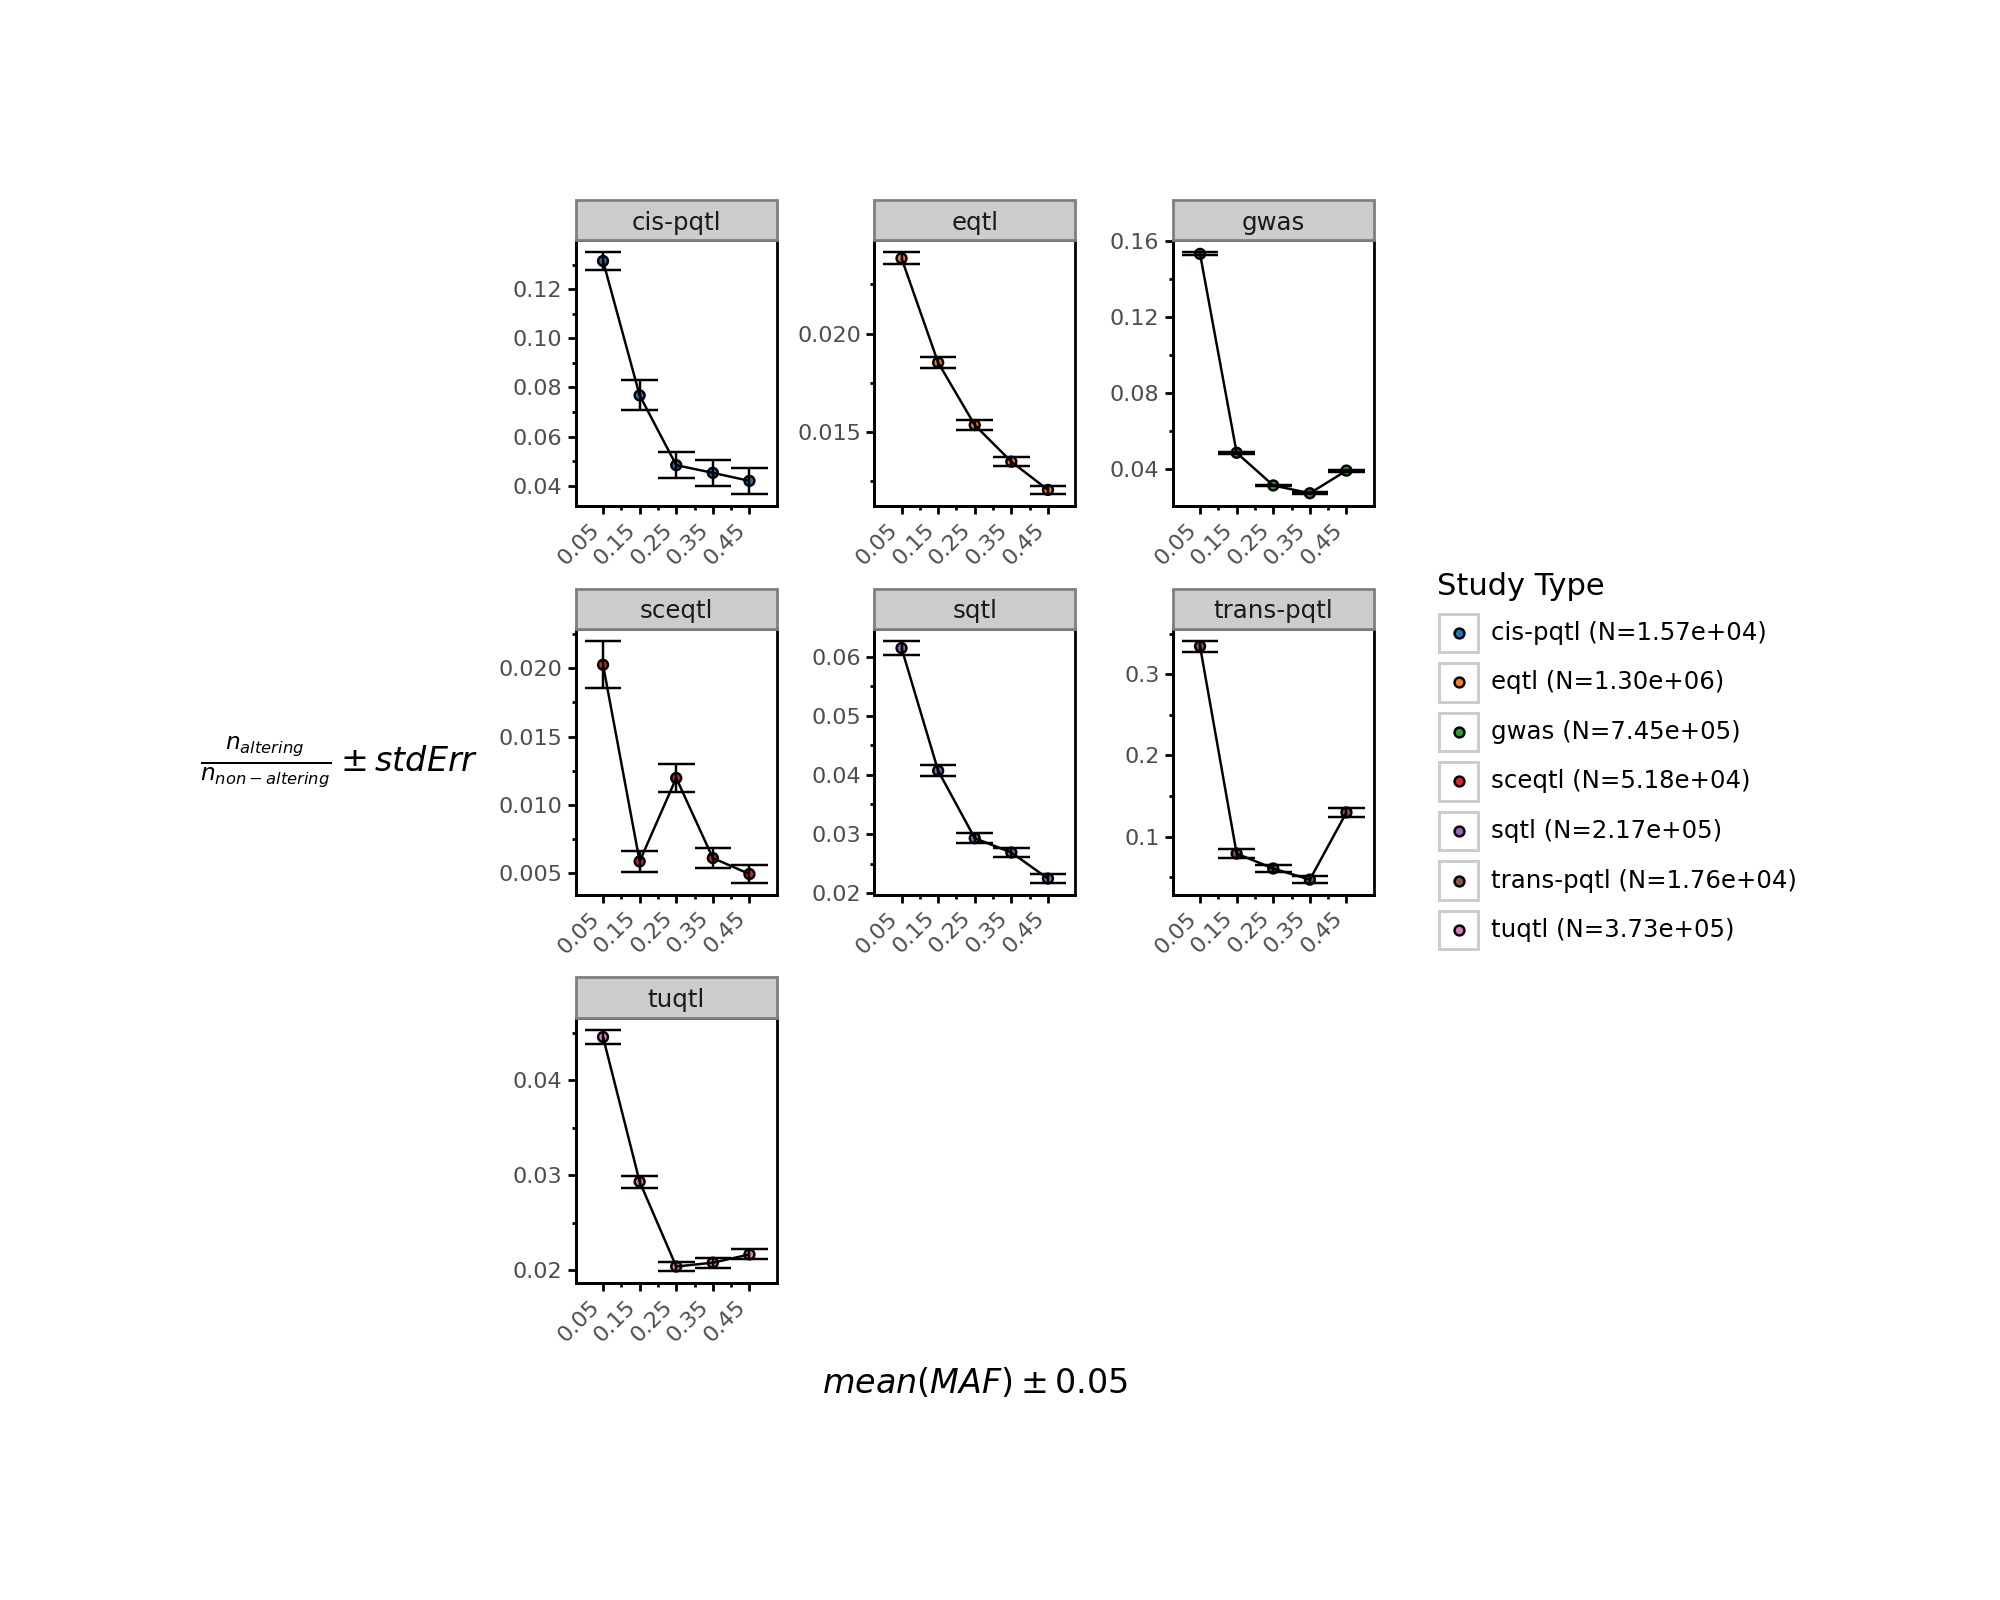

In [ ]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
REM = 10
plot = (
    pn.ggplot(
        data,
        pn.aes(
            x="midPoint",
            y="alteringNonAlteringProportionInBucket",
            fill="studyType",
        ),
    )
    + pn.geom_point()
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringNonAlteringProportionInBucket - stdErr",
            ymax="alteringNonAlteringProportionInBucket + stdErr",
        ),
        width=0.1,
    )
    + pn.theme_bw()
    + pn.labs(
        x=r"$mean(MAF)\pm{0.05}$",
        y=r"$\frac{n_{altering}}{n_{non-altering}}\pm{stdErr}$ ",
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + pn.theme(
        figure_size=(10, 8),  # ~85mm wide
        axis_title_x=pn.element_text(size=REM * 1.2, family="sans-serif"),
        axis_text=pn.element_text(size=REM * 0.8, family="sans-serif"),
        axis_title_y=pn.element_text(size=REM * 1.2, family="sans-serif", rotation=0, vjust=0.5),
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        axis_ticks=pn.element_line(color="black"),
        axis_line=pn.element_line(color="black"),
        panel_background=pn.element_rect(fill="white"),
        panel_border=pn.element_rect(color="black", fill=None),
        panel_grid=pn.element_blank(),
        plot_margin=0.1,
    )
    + pn.facet_wrap(nrow=3, ncol=3, facets="studyType", scales="free")
    + pn.geom_line()
    + pn.scale_fill_manual(
        values=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"],
        name="Study Type",
        labels=totals_map,
    )
)
plot


In [239]:
dataset_maf.df.groupBy("studyStatistics.studyType").agg(
    f.format_number(f.count("variantId"), 2).alias("totalVariants")
).show()


+----------+-------------+
| studyType|totalVariants|
+----------+-------------+
|  cis-pqtl|    16,053.00|
|      gwas|   789,453.00|
|      sqtl|   223,500.00|
|     tuqtl|   384,852.00|
|      eqtl| 1,349,478.00|
|trans-pqtl|    17,678.00|
|    sceqtl|    52,744.00|
+----------+-------------+



## Data


## Plot the MAF vs protein altering - VEP score


Text(0.5, 1.0, 'VEP normalised score vs Mean MAF')

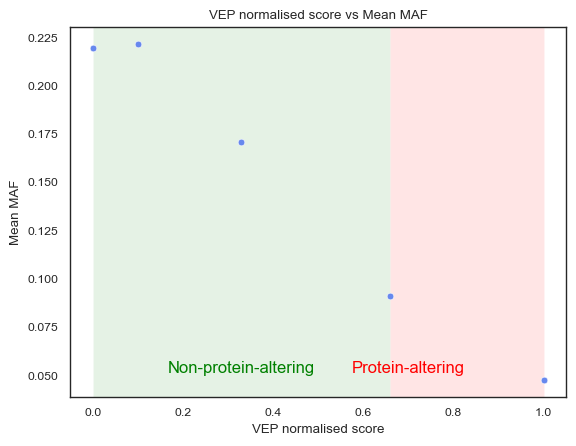

In [23]:
ax = sns.scatterplot(maf_vep_agg, x="normalisedScore", y="meanMAF")
protein_alt = patches.Rectangle(
    xy=(0.66, 0.00), height=0.25, width=0.34, linewidth=1, facecolor="red", zorder=-1, alpha=0.1
)
non_protein_alt = patches.Rectangle(
    xy=(0.00, 0.00), height=0.25, width=0.66, linewidth=1, facecolor="green", zorder=-1, alpha=0.1
)
ax.add_patch(non_protein_alt)
ax.add_patch(protein_alt)
ax.text(
    0.7,
    0.05,
    "Protein-altering",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
    color="red",
)
ax.text(
    0.33,
    0.05,
    "Non-protein-altering",
    horizontalalignment="center",
    verticalalignment="bottom",
    fontsize=12,
    color="green",
)
plt.xlabel("VEP normalised score")
plt.ylabel("Mean MAF")
plt.title("VEP normalised score vs Mean MAF")


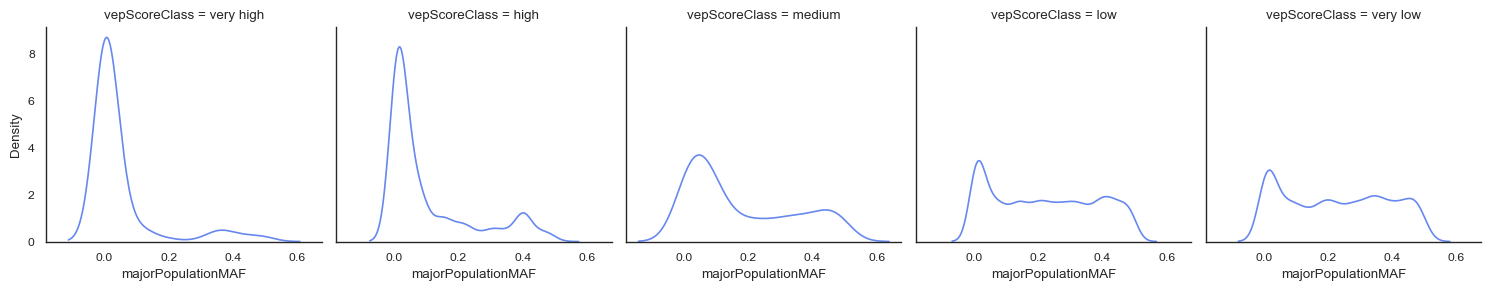

In [5]:
data = (
    replicated_lead_variants_dataset.filter(pl.col("studyType") == "gwas")
    .select("majorPopulationMAF", pl.col("vepScoreClass"), pl.col("vepEffect").struct.field("normalisedScore"))
    .sort("normalisedScore", descending=True)
)

fig = sns.FacetGrid(data=data, col="vepScoreClass")
fig.map_dataframe(sns.kdeplot, x="majorPopulationMAF")


<Axes: xlabel='majorPopulationMAF', ylabel='Density'>

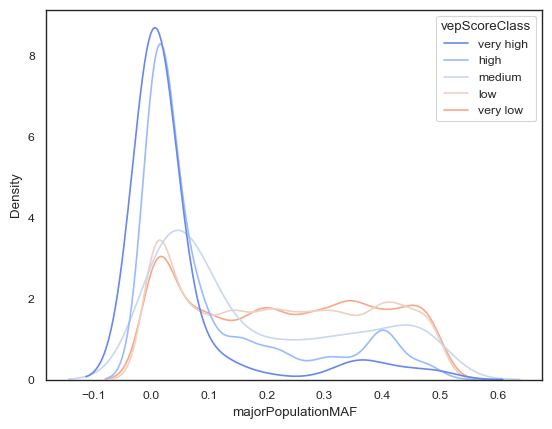

In [7]:
sns.kdeplot(data=data, x="majorPopulationMAF", hue="vepScoreClass", common_norm=False)


## Binned maf vs vep_score proportion


Number of data points in <0.1, 0.2) MAF bin: 0
Number of protein-coding variants in <0.1, 0.2) MAF bin: 0
shape: (0, 4)
┌─────────────────────────┬────────────────────────────┬────────────┬────────┐
│ proteinAlteringInMAFBin ┆ nonProteinAlteringInMAFBin ┆ proportion ┆ stdErr │
│ ---                     ┆ ---                        ┆ ---        ┆ ---    │
│ i32                     ┆ u32                        ┆ f64        ┆ f64    │
╞═════════════════════════╪════════════════════════════╪════════════╪════════╡
└─────────────────────────┴────────────────────────────┴────────────┴────────┘
shape: (11, 5)
┌──────────────┬────────────┬──────────┬────────────────────┬───────────┐
│ MAFBin       ┆ proportion ┆ stdErr   ┆ majorPopulationMAF ┆ nVariants │
│ ---          ┆ ---        ┆ ---      ┆ ---                ┆ ---       │
│ str          ┆ f64        ┆ f64      ┆ f64                ┆ u32       │
╞══════════════╪════════════╪══════════╪════════════════════╪═══════════╡
│ <0.0, 0.01)  ┆ 0.44

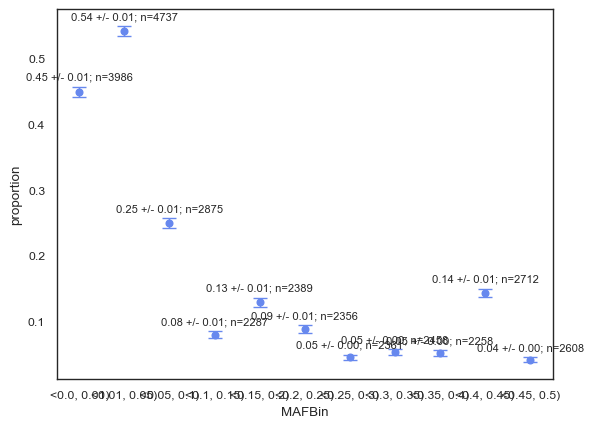

In [9]:
data = (
    replicated_lead_variants_dataset.filter(pl.col("studyType") == "gwas")
    .with_columns(
        vep_score_proportion(pl.col("vepEffect"), pl.col("MAFBin")),
    )
    .select(
        pl.col("vepProportion").struct.unnest(),
        pl.col("variantId"),
        pl.col("majorPopulationMAF"),
        pl.col("MAFBin"),
        pl.col("vepEffect").struct.field("normalisedScore"),
    )
)
# sanity check
n_data_group = data.filter(pl.col("MAFBin") == "<0.1, 0.2)").shape[0]
n_data_protein_coding = data.filter(pl.col("MAFBin") == "<0.1, 0.2)").filter(pl.col("normalisedScore") >= 0.66).shape[0]
print(f"Number of data points in <0.1, 0.2) MAF bin: {n_data_group}")
print(f"Number of protein-coding variants in <0.1, 0.2) MAF bin: {n_data_protein_coding}")
# print(
#     f"Proportion of protein-coding variants in <0.1, 0.2) MAF bin: {n_data_protein_coding / (n_data_group - n_data_protein_coding):.2%}"
# )
actual = data.filter(pl.col("MAFBin") == "<0.1, 0.2)").select(
    "proteinAlteringInMAFBin",
    "nonProteinAlteringInMAFBin",
    "proportion",
    "stdErr",
)
print(actual.limit(1))

grouped_data = (
    data.group_by("MAFBin")
    .agg(
        pl.first("proportion"),
        pl.first("stdErr"),
        pl.mean("majorPopulationMAF"),
        pl.count("variantId").alias("nVariants"),
    )
    .sort("majorPopulationMAF", descending=False)
)
print(grouped_data)

# Plotting the proportion of protein-altering variants in different MAF bins
fig = sns.scatterplot(data=grouped_data, x="MAFBin", y="proportion")
fig.errorbar(
    x=grouped_data["MAFBin"],
    y=grouped_data["proportion"],
    yerr=grouped_data["stdErr"],
    fmt="o",
    capsize=5,
    elinewidth=1,
    markeredgewidth=1,
)
# Add labels to the points
for i, row in grouped_data.to_pandas().iterrows():
    fig.text(
        x=i,
        y=row["proportion"] + row["stdErr"] + 0.01,
        s=f"{row['proportion']:.2f} +/- {row['stdErr']:.2f}; n={row['nVariants']}",
        horizontalalignment="center",
        fontsize=8,
    )


In [ ]:
replicated_lead_variants_dataset.write_parquet(
    "../../data/replicated-lead-variants.parquet",
)


In [34]:
from gentropy.dataset.variant_index import VariantIndex

vi = VariantIndex.from_parquet(session, "../../data/variant")
vi.filter(f.col("variantId") == "18_55779143_G_A").df.select(
    "variantId", f.explode("transcriptConsequences").alias("tc"), "variantEffect"
).select("variantId", "tc.consequenceScore", "variantEffect").show(truncate=False)


+---------------+----------------+-----------------------------------------------------------------------------------------------------------------+
|variantId      |consequenceScore|variantEffect                                                                                                    |
+---------------+----------------+-----------------------------------------------------------------------------------------------------------------+
|18_55779143_G_A|0.0             |[{VEP, non_coding_transcript_exon_variant, 0.0, NULL, NULL, 0.0}, {GERP, NULL, -4.9, NULL, ENSG00000267028, 0.0}]|
|18_55779143_G_A|0.0             |[{VEP, non_coding_transcript_exon_variant, 0.0, NULL, NULL, 0.0}, {GERP, NULL, -4.9, NULL, ENSG00000267028, 0.0}]|
|18_55779143_G_A|0.0             |[{VEP, non_coding_transcript_exon_variant, 0.0, NULL, NULL, 0.0}, {GERP, NULL, -4.9, NULL, ENSG00000267028, 0.0}]|
|18_55779143_G_A|0.0             |[{VEP, non_coding_transcript_exon_variant, 0.0, NULL, NULL, 0.0}, {GERP,